In [44]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [78]:
n_actions = 101
prices = np.linspace(0, 1, n_actions)
cost = 0.2

n_trials = 10
n_days = 10000
users_per_day = 100
n_intervals = 6
days_per_interval = n_days // n_intervals

interval_variance = 2
dist_noise = 0.1

In [63]:
class NoisyNonStationaryEnvironment:
    def __init__(self, prices, noise_level = 0):
        self.noise_level = noise_level
        self.prices = prices
        self.n_actions = len(prices)

    def generate_prob_dist(self, beta_parameter):
        # Beta will be our parameter
        alpha = 1
        purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta_parameter * self.prices)))

        # Noise
        noisy_purchase_probabilities = purchase_probabilities + np.random.normal(0, self.noise_level, self.n_actions)

        # purchase probability in [0,1]
        noisy_purchase_probabilities = np.clip(noisy_purchase_probabilities, 0, 1)

        return noisy_purchase_probabilities

In [79]:
# GENERATE THE PURCHASE PROBABILITY MATRIX

purchase_prob_matrix = np.empty((n_days, n_actions))

env = NoisyNonStationaryEnvironment(prices, dist_noise)

beta_params = [-5]
for day in range(n_days):
  # This checks whether we are at the first day of the next interval.
  # If so, generate a new beta by perturbing the old one
  if day // days_per_interval == len(beta_params):
    new_beta = beta_params[-1] + np.random.normal(0, interval_variance)
    beta_params.append(new_beta)

  purchase_prob_matrix[day, :] = env.generate_prob_dist(beta_params[-1])

n_purchase_matrix = np.random.binomial(users_per_day, purchase_prob_matrix)
profit_matrix = n_purchase_matrix * (prices - cost)

# Compute the baseline for the regret as the optimal policy in hindsight
optimal_policy_reward = np.max(profit_matrix, axis=1)

In [80]:
class UCB1Agent:
    def __init__(self, K, T):
        self.K = K
        self.T = T
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t
        else:
            ucbs = self.average_rewards + np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

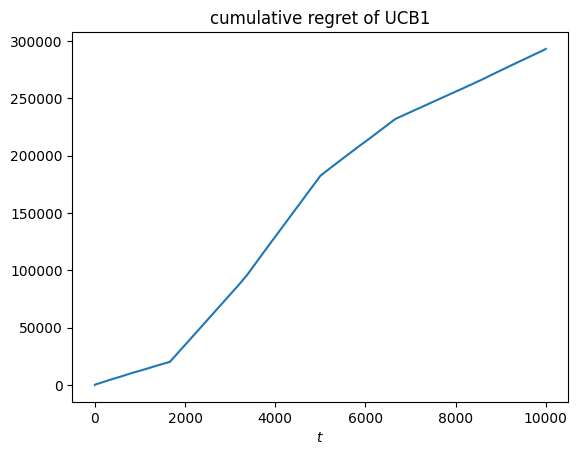

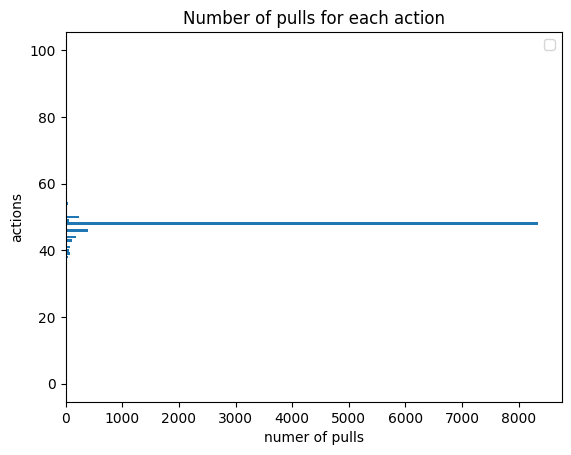

In [81]:
regret_per_trial = []

for _ in range(n_trials):
  ucb_agent = UCB1Agent(n_actions, n_days)
  agent_rewards = []

  for day in range(n_days):
    action = ucb_agent.pull_arm()
    price = prices[action]
    rew = profit_matrix[day, action]
    ucb_agent.update(rew)

    agent_rewards.append(rew)

  cumulative_regret = np.cumsum(optimal_policy_reward - np.asarray(agent_rewards))
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(n_days), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(n_days),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.show()

plt.figure()
plt.barh(np.arange(n_actions), ucb_agent.N_pulls)
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

In [67]:
class SWUCBAgent:
    def __init__(self, K, T, W):
        self.K = K
        self.T = T
        self.W = W
        self.a_t = None
        self.cache = np.repeat(np.nan, repeats=K*W).reshape(W, K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            avg_last_w = np.nanmean(self.cache, axis=0)
            ucbs = avg_last_w + np.sqrt(2*np.log(self.W)/n_pulls_last_w) # there's a typo in the slides, log(T) -> log(W)
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.cache = np.delete(self.cache, (0), axis=0) # remove oldest observation
        new_samples = np.repeat(np.nan, self.K)
        new_samples[self.a_t] = r_t
        self.cache = np.vstack((self.cache, new_samples)) # add new observation
        self.t += 1

<ipython-input-67-9cf3d7db95dc>:16: RuntimeWarning: Mean of empty slice
  avg_last_w = np.nanmean(self.cache, axis=0)
<ipython-input-67-9cf3d7db95dc>:17: RuntimeWarning: divide by zero encountered in divide
  ucbs = avg_last_w + np.sqrt(2*np.log(self.W)/n_pulls_last_w) # there's a typo in the slides, log(T) -> log(W)


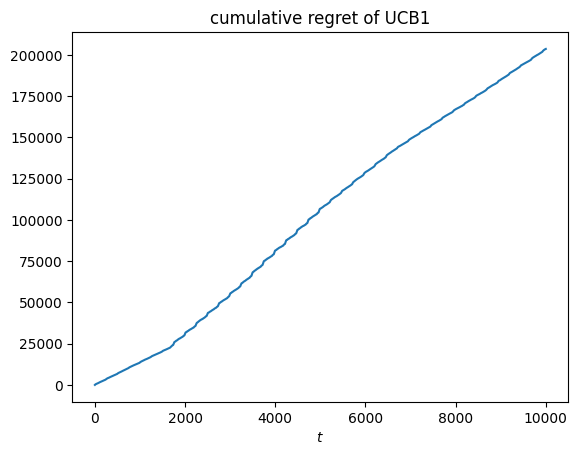

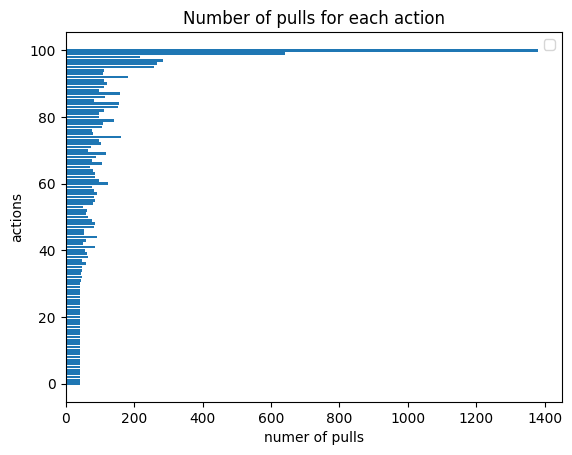

In [82]:
regret_per_trial = []
W = int(2*np.sqrt(n_days*np.log(n_days)/n_intervals))
for _ in range(n_trials):
  ucb_agent = SWUCBAgent(n_actions, n_days, W)
  agent_rewards = []

  for day in range(n_days):
    action = ucb_agent.pull_arm()
    price = prices[action]
    rew = profit_matrix[day, action]
    ucb_agent.update(rew)

    agent_rewards.append(rew)

  cumulative_regret = np.cumsum(optimal_policy_reward - np.asarray(agent_rewards))
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(n_days), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(n_days),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.show()

plt.figure()
plt.barh(np.arange(n_actions), ucb_agent.N_pulls)
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

In [83]:
class CUSUMUCBAgent:
    def __init__(self, K, T, M, h, alpha=0.99):
        self.K = K
        self.T = T
        self.M = M
        self.h = h
        self.alpha=alpha
        self.a_t = None
        self.reset_times = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.all_rewards = [[] for _ in np.arange(K)]
        self.counters = np.repeat(M, K)
        self.average_rewards = np.zeros(K)
        self.n_resets = np.zeros(K)
        self.n_t = 0
        self.t = 0

    def pull_arm(self):
        if (self.counters > 0).any():
            for a in np.arange(self.K):
                if self.counters[a] > 0:
                    self.counters[a] -= 1
                    self.a_t = a
                    break
        else:
            if np.random.random() <= 1-self.alpha:
                ucbs = self.average_rewards + np.sqrt(np.log(self.n_t)/self.N_pulls)
                self.a_t = np.argmax(ucbs)
            else:
                self.a_t = np.random.choice(np.arange(self.K)) # extra exploration
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.all_rewards[self.a_t].append(r_t)
        if self.counters[self.a_t] == 0:
            if self.change_detection():
                self.n_resets[self.a_t] +=1
                self.N_pulls[self.a_t] = 0
                self.average_rewards[self.a_t] = 0
                self.counters[self.a_t] = self.M
                self.all_rewards[self.a_t] = []
                self.reset_times[self.a_t] = self.t
            else:
                self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.n_t = sum(self.N_pulls)
        self.t += 1

    def change_detection(self):
        ''' CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm has its average reward changed '''
        u_0 = np.mean(self.all_rewards[self.a_t][:self.M])
        sp, sm = (np.array(self.all_rewards[self.a_t][self.M:])- u_0, u_0 - np.array(self.all_rewards[self.a_t][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gp, gm]) >= self.h:
                return True
        return False

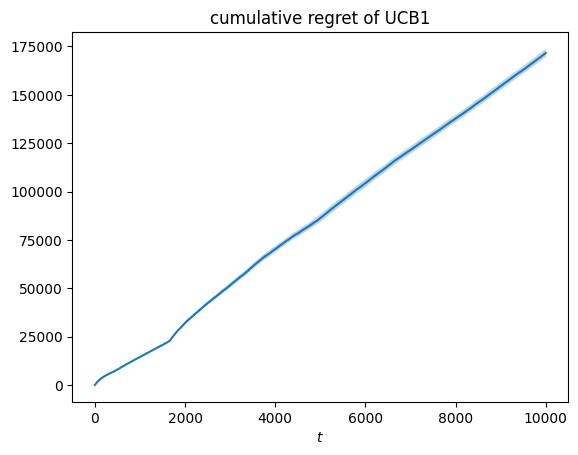

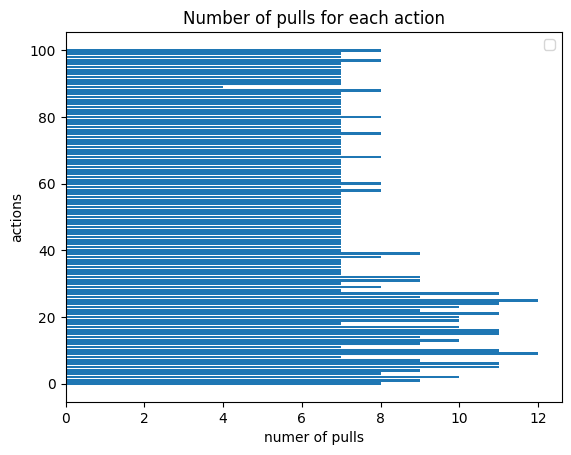

In [85]:
regret_per_trial = []
h = 2*np.log(n_days/n_intervals)
alpha = np.sqrt(n_intervals*np.log(n_days/n_intervals)/n_days)

M = int(np.log(n_days/n_intervals))
for _ in range(n_trials):
  ucb_agent = CUSUMUCBAgent(n_actions, n_days, M, h, alpha)
  agent_rewards = []

  for day in range(n_days):
    action = ucb_agent.pull_arm()
    price = prices[action]
    rew = profit_matrix[day, action]
    ucb_agent.update(rew)

    agent_rewards.append(rew)

  cumulative_regret = np.cumsum(optimal_policy_reward - np.asarray(agent_rewards))
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(n_days), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(n_days),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.show()

plt.figure()
plt.barh(np.arange(n_actions), ucb_agent.N_pulls)
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();